<a href="https://colab.research.google.com/github/chi-hun/chi-hun/blob/main/datasetmake(image).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [447]:
import tensorflow as tf
from tensorflow.keras import layers
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import glob
import cv2
import tqdm
import time
from functools import partial
autotune = tf.data.experimental.AUTOTUNE

# tf.data 사용

## 이미지 넘파이 배열(이미 준비된 데이터)

In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.1)

In [ ]:
img_size = 30
# albumentations 변환 
transformer = A.Compose([A.HorizontalFlip(),
                         A.ShiftScaleRotate(),
                         A.RandomBrightnessContrast(),
                         A.RandomFog(),
                         A.Rotate(20)
                         ])

def rescsi(image, label=None): # 이미지 리스케일 및 리사이즈
    image = tf.cast(image/255, tf.float32)
    image = tf.image.resize(image, size=(img_size, img_size))
    image = tf.reshape(image, (30,30,3))
    return image, label

def argument(image, label): # 이미지 데이터 증강
    image = transformer(image=image)['image']
    image,label = rescsi(image, label) # 트레인데이터 경우 리스케일링, 리사이즈 동시 진행
    return image, label

def numpy_tf(image, label): # 텐서 넘파이 함수 화
    image, label = tf.numpy_function(func=argument, inp=[image, label], Tout=[tf.float32, tf.uint8])
    image.set_shape((img_size,img_size,3)) #텐서 크기 재지정 (지정 안할시 모델 훈련 오류발생)
    label.set_shape((1,))
    return image, label

def make_dataset(image, label=None, train=False):
    if label is not None  : 
        dataset = tf.data.Dataset.from_tensor_slices((image, label))       
    else : # 라벨이 없을경우(test 데이터)
        dataset = tf.data.Dataset.from_tensor_slices((image))
    
    if train : # train 데이터 경우 데이터 증가, 셔플
        dataset = dataset.map(numpy_tf).shuffle(1024).batch(32)
    else :
        dataset = dataset.map(rescsi, num_parallel_calls=autotune).batch(32).prefetch(buffer_size=autotune)

    return dataset

In [387]:
train_ds = make_dataset(x_train, y_train, True)
validation_ds = make_dataset(x_val, y_val, False)
test_ds = make_dataset(x_test,train=False)

NameError: ignored

In [ ]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_16  (None, 64)               0  

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1407/1407 [==============================] - 96s 67ms/step - loss: 1.9596 - accuracy: 0.2542 - val_loss: 1.7543 - val_accuracy: 0.3278
Epoch 2/10
1407/1407 [==============================] - 98s 69ms/step - loss: 1.7657 - accuracy: 0.3385 - val_loss: 1.6549 - val_accuracy: 0.3934
Epoch 3/10
1407/1407 [==============================] - 88s 62ms/step - loss: 1.6778 - accuracy: 0.3816 - val_loss: 1.5764 - val_accuracy: 0.4244
Epoch 4/10
1407/1407 [==============================] - 87s 61ms/step - loss: 1.6075 - accuracy: 0.4141 - val_loss: 1.5331 - val_accuracy: 0.4332
Epoch 5/10
1407/1407 [==============================] - 86s 61ms/step - loss: 1.5600 - accuracy: 0.4328 - val_loss: 1.4808 - val_accuracy: 0.4608
Epoch 6/10
1407/1407 [==============================] - 86s 61ms/step - loss: 1.5287 - accuracy: 0.4459 - val_loss: 1.4218 - val_accuracy: 0.4772
Epoch 7/10
1407/1407 [==============================] - 86s 60ms/step - loss: 1.4977 - accuracy: 0.4577 - val_loss: 1.3545 -

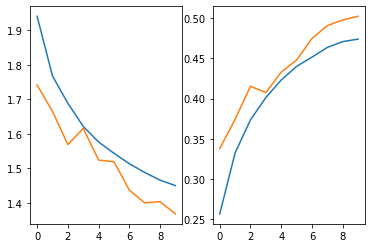

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

## 이미지 파일(albumentations로 증강)

In [ ]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/공부/archi.zip'

In [ ]:
train_folder = '/content/cifar10/train'
test_folder = '/content/cifar10/test'
train_path = sorted(glob.glob(train_folder+'/*/*')) # 파일 경로 리스트
test_path = sorted(glob.glob(test_folder+'/*/*'))

In [ ]:
def label_make(path): # 파일명에서 라벨 추출(폴더별로 파일이 나눠져 있음)
    label = []
    for i in path:
        label.append(i.split('/')[-2])
    return label
train_label = label_make(train_path)
test_label = label_make(test_path)

In [ ]:
train_label = pd.get_dummies(train_label) # 원핫인코딩
test_label = pd.get_dummies(test_label)

In [ ]:
train_path, validation_path, train_label, validation_label = train_test_split(train_path, train_label, stratify=train_label, test_size=0.1) # 훈련, 검증셋 분리
len(train_path), len(validation_path), len(train_label), len(validation_label)

(45000, 5000, 45000, 5000)

In [ ]:
transformer = A.Compose([A.HorizontalFlip(), # 데이터 증가
                         A.ShiftScaleRotate(),
                         A.RandomBrightnessContrast(),
                         A.RandomFog(),
                         A.Rotate(20)
                         ])

img_size = 30 # 변경 이미지 사이즈(원본 32)

def make_image(path, label=None): # 이미지 경로에서 파일 블러와 텐서로 변경(image)
    image = tf.io.decode_image(tf.io.read_file(path), expand_animations = False)
    return image, label

def rescale_resize(image, label=None): # 이미지 정규화, 사이즈 조정
    image = tf.cast(image/255, tf.float32)
    image = tf.image.resize(image, size=((img_size, img_size)))
    return image, label

def argument(image, label): # 이미지 증가(리사이즈 동시 진행)
    image = transformer(image=image)['image']
    image, label = rescale_resize(image, label)
    return image, label

def num_fuc(image, label): #  이미지 넘파이 함수 텐서플로우 함수로 계산
    image, label = tf.numpy_function(func=argument, inp=[image, label], Tout=[tf.float32, tf.uint8])
    image.set_shape((img_size, img_size, 3)) # 출력되는 모양 재정의
    label.set_shape((10,))
    return image, label

def make_dataset(path, label=None, train=False): # 데이터 메이커(훈련, 검증, 테스트)
    if label is not None : # 테스트 데이터인지 확인
        dataset = tf.data.Dataset.from_tensor_slices((path, label))
        dataset = dataset.map(make_image)
    else :
        dataset = tf.data.Dataset.from_tensor_slices((path))
        dataset = dataset.map(make_image)

    if train: # 훈련용 데이터 인지 확인
        dataset = dataset.map(num_fuc, num_parallel_calls=autotune).shuffle(1024).batch(32).prefetch(buffer_size=autotune)
    else :
        dataset = dataset.map(rescale_resize, num_parallel_calls=autotune).batch(32).prefetch(buffer_size=autotune)

    return dataset

In [ ]:
train_ds = make_dataset(train_path, train_label, True)
validation_ds = make_dataset(validation_path, validation_label, train=False)
test_ds = make_dataset(test_path, train = False)

In [ ]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 64)               0     

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1407/1407 [==============================] - 105s 73ms/step - loss: 1.9469 - accuracy: 0.2581 - val_loss: 1.8073 - val_accuracy: 0.3162
Epoch 2/10
1407/1407 [==============================] - 104s 73ms/step - loss: 1.7597 - accuracy: 0.3409 - val_loss: 1.6440 - val_accuracy: 0.3964
Epoch 3/10
1407/1407 [==============================] - 115s 81ms/step - loss: 1.6560 - accuracy: 0.3918 - val_loss: 1.6519 - val_accuracy: 0.3996
Epoch 4/10
1407/1407 [==============================] - 105s 73ms/step - loss: 1.5918 - accuracy: 0.4172 - val_loss: 1.5814 - val_accuracy: 0.4388
Epoch 5/10
1407/1407 [==============================] - 109s 76ms/step - loss: 1.5505 - accuracy: 0.4343 - val_loss: 1.4705 - val_accuracy: 0.4704
Epoch 6/10
1407/1407 [==============================] - 103s 72ms/step - loss: 1.5168 - accuracy: 0.4531 - val_loss: 1.4208 - val_accuracy: 0.4908
Epoch 7/10
1407/1407 [==============================] - 104s 73ms/step - loss: 1.4825 - accuracy: 0.4651 - val_loss: 1

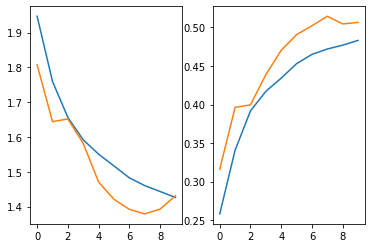

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

StratifiedKFold 사용

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

In [ ]:
epochs = 20
skf = StratifiedKFold(100, shuffle=True) # kfold
train_path, train_label = shuffle(train_path, train_label) # shuffle
skf_li = list(skf.split(train_path, train_label)) # kfold 실행결과 리스트
train_df = pd.DataFrame({'path':train_path, 'label':train_label}) # 데이터 프레임화

for epoch in range(epochs): # 훈련
    print(f'{epoch+1}/{epochs}')
    i, j = skf_li[epoch] # kfold 인덱스 반환
    train_path_x = train_df['path'][i].values # 훈련 데이터 프레임
    train_label_x = pd.get_dummies(train_df['label'][i].values)
    validation_path_x = train_df['path'][j].values # 검증 데이터 프레임
    validation_label_x = pd.get_dummies(train_df['label'][j].values) 
    train_ds = make_dataset(train_path_x, train_label_x, True) # 데이터셋 만들기
    validation_ds = make_dataset(validation_path_x, validation_label_x, False)
    his = model.fit(train_ds, epochs=1, validation_data=validation_ds) # 훈련

1/20
1547/1547 [==============================] - 88s 57ms/step - loss: 2.2255 - accuracy: 0.1579 - val_loss: 1.8637 - val_accuracy: 0.2900
2/20
1547/1547 [==============================] - 86s 55ms/step - loss: 1.8009 - accuracy: 0.3165 - val_loss: 1.6712 - val_accuracy: 0.3380
3/20
1547/1547 [==============================] - 87s 55ms/step - loss: 1.7007 - accuracy: 0.3674 - val_loss: 1.6154 - val_accuracy: 0.3800
4/20
1547/1547 [==============================] - 86s 55ms/step - loss: 1.6286 - accuracy: 0.4045 - val_loss: 1.5158 - val_accuracy: 0.4260
5/20
1547/1547 [==============================] - 88s 57ms/step - loss: 1.5707 - accuracy: 0.4279 - val_loss: 1.5424 - val_accuracy: 0.4440
6/20
1547/1547 [==============================] - 88s 57ms/step - loss: 1.5403 - accuracy: 0.4408 - val_loss: 1.3839 - val_accuracy: 0.4960
7/20
1547/1547 [==============================] - 93s 60ms/step - loss: 1.5023 - accuracy: 0.4550 - val_loss: 1.3391 - val_accuracy: 0.5260
8/20
1547/1547 [====

## 이미지(tf.image로 증강)

In [ ]:
def make_image(labeled):
    def read_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3) #jpeg, image
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, (img_size, img_size))
        return img
    
    def image_with_label(path, label):
        return read_image(path), label
    
    return image_with_label if labeled else read_image


def make_argument(labeled):
    def image_argument(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.05)
        img = tf.image.random_contrast(img, 0.95, 1.05) # 대비
        img = tf.image.random_hue(img, 0.05) # 색조
        img = tf.image.random_saturation(img, 0.95, 1.05) # 채도
        return img
    
    def argument_with_label(img, label):
        return image_argument(img), label

    return argument_with_label if labeled else image_argument


def make_dataset(path, label=None, labeled=False, img_size=300, batch=32, argument=False, repeat=False, shuffle=False):
    image_f = make_image(labeled)
    argument_f = make_argument(labeled)

    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices((path, label))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((path))
    dataset = dataset.map(image_f, num_parallel_calls=autotune)
    if argument:
        dataset = dataset.map(argument_f, num_parallel_calls=autotune)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(autotune)

    return dataset

In [ ]:
img_size = 30 # 변경 이미지 사이즈(원본 32)
train_ds = make_dataset(train_path, train_label.values, labeled=True, img_size=img_size, batch=32, argument=True, repeat=False, shuffle=True)
validation_ds = make_dataset(validation_path, validation_label.values, labeled=True, img_size=img_size, batch=32, argument=False, repeat=False, shuffle=False)

In [ ]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 64)               0     

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1407/1407 [==============================] - 88s 62ms/step - loss: 1.9035 - accuracy: 0.2718 - val_loss: 1.7505 - val_accuracy: 0.3146
Epoch 2/10
1407/1407 [==============================] - 88s 62ms/step - loss: 1.7092 - accuracy: 0.3535 - val_loss: 1.7220 - val_accuracy: 0.3640
Epoch 3/10
1407/1407 [==============================] - 90s 63ms/step - loss: 1.6177 - accuracy: 0.3976 - val_loss: 1.5601 - val_accuracy: 0.4198
Epoch 4/10
1407/1407 [==============================] - 84s 60ms/step - loss: 1.5461 - accuracy: 0.4317 - val_loss: 1.5081 - val_accuracy: 0.4450
Epoch 5/10
1407/1407 [==============================] - 85s 60ms/step - loss: 1.5000 - accuracy: 0.4519 - val_loss: 1.4651 - val_accuracy: 0.4624
Epoch 6/10
1407/1407 [==============================] - 84s 59ms/step - loss: 1.4653 - accuracy: 0.4665 - val_loss: 1.4284 - val_accuracy: 0.4796
Epoch 7/10
1407/1407 [==============================] - 87s 62ms/step - loss: 1.4311 - accuracy: 0.4789 - val_loss: 1.4195 -

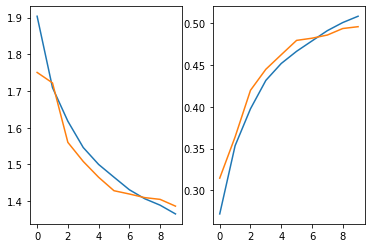

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

# tf.keras.utils.image_dataset_from_directory 사용

In [ ]:
train_path = '/content/cifar10/train'
test_path = '/content/cifar10/test'

In [ ]:
image_size = 30
train_ds = tf.keras.utils.image_dataset_from_directory(train_path, # 폴더별로 나눠저 있는 폴더 위치
                                                       image_size = (image_size, image_size), 
                                                       shuffle = True, # 훈련 데이터, 검증 데이터만 셔플 
                                                       batch_size = 32,
                                                       seed = 42, # shfuffle시 필수
                                                       subset = 'training',# 훈련 데이터
                                                       validation_split = 0.1) # 검증 데이터 비율
validation_ds = tf.keras.utils.image_dataset_from_directory(train_path,
                                                       image_size = (image_size, image_size),
                                                       shuffle = True,
                                                       batch_size = 32,
                                                       seed = 42,
                                                       subset = 'validation', # 검증 데이터
                                                       validation_split = 0.1)

Found 50000 files belonging to 10 classes.
Using 45000 files for training.
Found 50000 files belonging to 10 classes.
Using 5000 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_path,
                                                      image_size=(image_size,image_size),
                                                      shuffle=False, # 테스트 데이터 shuffle False
                                                      batch_size = 32,)

Found 10000 files belonging to 10 classes.


In [ ]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 64)               0   

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1407/1407 [==============================] - 54s 38ms/step - loss: 1.8890 - accuracy: 0.3370 - val_loss: 1.5414 - val_accuracy: 0.4222
Epoch 2/10
1407/1407 [==============================] - 54s 39ms/step - loss: 1.5093 - accuracy: 0.4474 - val_loss: 1.4121 - val_accuracy: 0.4740
Epoch 3/10
1407/1407 [==============================] - 51s 36ms/step - loss: 1.3698 - accuracy: 0.5058 - val_loss: 1.2918 - val_accuracy: 0.5338
Epoch 4/10
1407/1407 [==============================] - 54s 39ms/step - loss: 1.2963 - accuracy: 0.5355 - val_loss: 1.2827 - val_accuracy: 0.5432
Epoch 5/10
1407/1407 [==============================] - 54s 38ms/step - loss: 1.2340 - accuracy: 0.5610 - val_loss: 1.2607 - val_accuracy: 0.5524
Epoch 6/10
1407/1407 [==============================] - 55s 39ms/step - loss: 1.1843 - accuracy: 0.5773 - val_loss: 1.1893 - val_accuracy: 0.5780
Epoch 7/10
1407/1407 [==============================] - 55s 39ms/step - loss: 1.1438 - accuracy: 0.5956 - val_loss: 1.1144 -

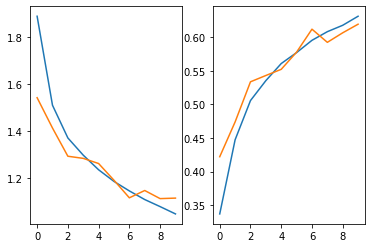

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

데이터 증강 

In [ ]:
inputs = layers.Input(shape=(30,30,3))
x = layers.experimental.preprocessing.RandomFlip('horizontal')(inputs) # 데이터 증강 레이어1
x = layers.experimental.preprocessing.RandomRotation(0.1)(x) # 데이터 증강 레이어2
x = layers.experimental.preprocessing.RandomContrast(0.1)(x) # 데이터 증강 레이어3
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d_2   (None, 64)               0   

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1407/1407 [==============================] - 53s 37ms/step - loss: 1.8592 - accuracy: 0.3549 - val_loss: 1.5201 - val_accuracy: 0.4214
Epoch 2/10
1407/1407 [==============================] - 52s 37ms/step - loss: 1.4592 - accuracy: 0.4708 - val_loss: 1.4459 - val_accuracy: 0.4696
Epoch 3/10
1407/1407 [==============================] - 52s 37ms/step - loss: 1.3535 - accuracy: 0.5152 - val_loss: 1.3552 - val_accuracy: 0.5136
Epoch 4/10
1407/1407 [==============================] - 51s 37ms/step - loss: 1.2796 - accuracy: 0.5440 - val_loss: 1.2096 - val_accuracy: 0.5734
Epoch 5/10
1407/1407 [==============================] - 54s 38ms/step - loss: 1.2218 - accuracy: 0.5685 - val_loss: 1.2815 - val_accuracy: 0.5422
Epoch 6/10
1407/1407 [==============================] - 53s 38ms/step - loss: 1.1765 - accuracy: 0.5830 - val_loss: 1.2277 - val_accuracy: 0.5698
Epoch 7/10
1407/1407 [==============================] - 57s 40ms/step - loss: 1.1337 - accuracy: 0.5994 - val_loss: 1.2279 -

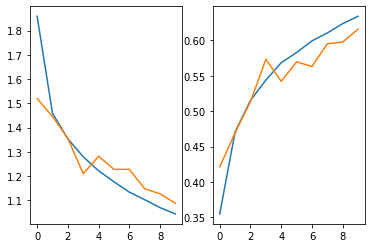

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

# tf.keras.preprocessing.image.ImageDataGenerator

In [ ]:
train_folder = '/content/cifar10/train'
test_folder = '/content/cifar10/test'
train_path = sorted(glob.glob(train_folder+'/*/*')) # 파일 경로 리스트
test_path = sorted(glob.glob(test_folder+'/*/*'))

In [ ]:
def label_make(path): # 파일명에서 라벨 추출(폴더별로 파일이 나눠져 있음)
    label = []
    for i in path:
        label.append(i.split('/')[-2])
    return label
train_label = label_make(train_path)
test_label = label_make(test_path)

In [ ]:
train_df = pd.DataFrame({'path' : train_path, 'label' : train_label})

In [ ]:
train_ge = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           rotation_range=20,
                                                           width_shift_range=0.2,
                                                           height_shift_range=0.2,
                                                           shear_range=0.2,
                                                           zoom_range=0.2,
                                                           horizontal_flip=True,
                                                           vertical_flip=True,
                                                           data_format="channels_last",
                                                           validation_split=0.10)

In [ ]:
train_ds = train_ge.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', batch_size=32, target_size=(30,30), shuffle=True, subset='training', class_mode='categorical')
val_ds = train_ge.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', batch_size=32, target_size=(30,30), shuffle=True, subset='validation', class_mode='categorical')

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.


In [ ]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d_2   (None, 64)               0   

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
his = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1407/1407 [==============================] - 65s 46ms/step - loss: 1.9048 - accuracy: 0.2657 - val_loss: 10.5283 - val_accuracy: 0.0000e+00
Epoch 2/10
1407/1407 [==============================] - 67s 48ms/step - loss: 1.7387 - accuracy: 0.3329 - val_loss: 12.9062 - val_accuracy: 0.0000e+00
Epoch 3/10
1407/1407 [==============================] - 66s 47ms/step - loss: 1.6805 - accuracy: 0.3636 - val_loss: 15.7488 - val_accuracy: 0.0000e+00
Epoch 4/10
1407/1407 [==============================] - 66s 47ms/step - loss: 1.6283 - accuracy: 0.3913 - val_loss: 18.2676 - val_accuracy: 0.0000e+00
Epoch 5/10
 402/1407 [=======>......................] - ETA: 45s - loss: 1.6013 - accuracy: 0.4013

KeyboardInterrupt: ignored

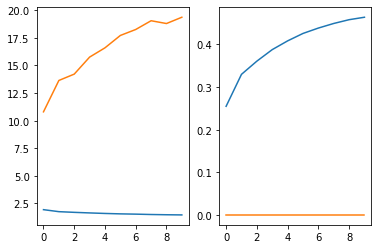

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

# tensorflow.keras.utils.Sequence  사용

In [312]:
train_folder = '/content/cifar10/train'
test_folder = '/content/cifar10/test'
train_path = sorted(glob.glob(train_folder+'/*/*')) # 파일 경로 리스트
test_path = sorted(glob.glob(test_folder+'/*/*'))

In [313]:
def label_make(path): # 파일명에서 라벨 추출(폴더별로 파일이 나눠져 있음)
    label = []
    for i in path:
        label.append(i.split('/')[-2])
    return label
train_label = label_make(train_path)
test_label = label_make(test_path)

In [314]:
train_path, validation_path, train_label, validation_label = train_test_split(train_path, train_label, test_size=0.1, stratify=train_label)

In [315]:
classes = pd.get_dummies(train_label).columns
train_label = pd.get_dummies(train_label).values
validation_label = pd.get_dummies(validation_label).values

In [316]:
transformer = A.Compose([A.HorizontalFlip(), # 데이터 증가
                         A.ShiftScaleRotate(),
                         A.RandomBrightnessContrast(),
                         A.RandomFog(),
                         A.Rotate(20)
                         ])

def make_argument(image): # 데이터 증강
    image = transformer(image=image)['image']
    return image

class data_make(tf.keras.utils.Sequence):
    def __init__(self, path, label=None, batch_size = 32, image_size=32, argument=False, shuffle=False, prepro=None):
        self.path = path
        self.batch_size = batch_size 
        self.image_size = image_size
        self.argument = argument
        self.shuffle = shuffle
        self.label = label
        self.prepro = prepro

        if self.shuffle : # 셔플이 True이면 셔플 진행
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.path) / self.batch_size))

    def __getitem__(self, index):
        path_sel = self.path[index*self.batch_size:(index+1)*self.batch_size] # 배치 크기만큼 선택
        if self.label is not None: # 라벨이 있을시 라벨도
            label_sel = self.label[index*self.batch_size:(index+1)*self.batch_size]

        image = np.zeros((len(path_sel), self.image_size, self.image_size, 3), dtype=np.float32) # 이미지 파일의 판 
        for i in range(len(path_sel)): # 이미지를 opencv로 읽고 색변경, 사이즈 조정
            img = cv2.cvtColor(cv2.imread(path_sel[i]),cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.image_size, self.image_size))
            if self.argument: # 훈련파일이면 데이터 증강
                img = make_argument(img)
            if self.prepro is not None:
                img = self.prepro(img)
            # img = tf.cast(img/255, dtype = tf.float32) # 이미지 정규화
            image[i] = img #판에 추가
            # image = tf.cast(image, tf.float32) #텐서화
            # image.set_shape((len(path_sel), self.image_size, self.image_size, 3))

        if self.label is not None:
            return image, np.array(label_sel)
        else:
            return image

    def on_epoch_end(self): # 1에포크 종료시 데이터 셔플
        if self.shuffle:
            self.path, self.label = sklearn.utils.shuffle(self.path, self.label)
        else:
            pass

In [317]:
train_ds = data_make(train_path, train_label, image_size = 30, argument = True, shuffle=True)
validation_ds = data_make(validation_path, validation_label, image_size = 30, argument = False, shuffle=False)
test_ds = data_make(test_path, image_size = 30, argument = False, shuffle=False)

In [328]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_9   (None, 64)               0   

In [329]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [327]:
time_now = time.time()
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)
print(time.time() - time_now)

Epoch 1/10
1407/1407 [==============================] - 78s 55ms/step - loss: 1.9932 - accuracy: 0.3068 - val_loss: 1.6052 - val_accuracy: 0.4228
Epoch 2/10
1407/1407 [==============================] - 66s 47ms/step - loss: 1.6325 - accuracy: 0.4099 - val_loss: 1.5378 - val_accuracy: 0.4392
Epoch 3/10
1407/1407 [==============================] - 68s 48ms/step - loss: 1.5471 - accuracy: 0.4463 - val_loss: 1.5005 - val_accuracy: 0.4614
Epoch 4/10
1407/1407 [==============================] - 61s 44ms/step - loss: 1.4940 - accuracy: 0.4648 - val_loss: 1.3471 - val_accuracy: 0.5200
Epoch 5/10
1407/1407 [==============================] - 61s 43ms/step - loss: 1.4535 - accuracy: 0.4820 - val_loss: 1.3578 - val_accuracy: 0.5070
Epoch 6/10
1407/1407 [==============================] - 65s 47ms/step - loss: 1.4229 - accuracy: 0.4910 - val_loss: 1.3059 - val_accuracy: 0.5292
Epoch 7/10
1407/1407 [==============================] - 61s 43ms/step - loss: 1.3866 - accuracy: 0.5094 - val_loss: 1.2305 -

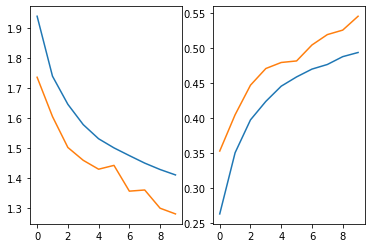

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

# TFRecord

In [430]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/공부/archi.zip'
train_folder = '/content/cifar10/train'
test_folder = '/content/cifar10/test'
train_path = sorted(glob.glob(train_folder+'/*/*')) # 파일 경로 리스트
test_path = sorted(glob.glob(test_folder+'/*/*'))

In [431]:
def label_make(path): # 파일명에서 라벨 추출(폴더별로 파일이 나눠져 있음)
    label = []
    for i in path:
        label.append(i.split('/')[-2])
    return label
train_label = label_make(train_path)
test_label = label_make(test_path)
train_label = pd.get_dummies(train_label).values
test_label = pd.get_dummies(test_label).values

In [432]:
train_path, validation_path, train_label, validation_label = train_test_split(train_path, train_label, test_size=0.1, stratify=train_label)

In [335]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.
# 형식별로 feature 변형
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value): # Returns a float_list from a float / double
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value): # Returns an int64_list from a bool / enum / int / uint
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [442]:
img_size = 30
def make_tfr(file_name, file_path, label_value=None, img_size=img_size):
    tfr_writer = tf.io.TFRecordWriter(file_name) # tfr 라이터 
    for i in tqdm.tqdm(range(len(file_path))):
        img = cv2.imread(train_path[i]) # 이미지를 읽어서 사이즈 변형 후 바이트화
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img.tobytes()

        if label_value is not None: # 라벨이 있을시
            label = label_value[i] # 라벨도 바이트화
            label = label.tobytes()

            # example 형식 만들기
            example = tf.train.Example(features=
                                       tf.train.Features(feature={
                                           'image' : _bytes_feature(img),
                                           'label' : _bytes_feature(label)
                                       }))
            tfr_writer.write(example.SerializeToString()) #binary string으로 변경후 저장

        else: # 라벨이 없을시
            example = tf.train.Example(features=
                                       tf.train.Features(feature={
                                           'image' : _bytes_feature(img)
                                       }))

    tfr_writer.close()

In [443]:
make_tfr('train.tfr', train_path, train_label, img_size = 30)
make_tfr('validation.tfr', validation_path, validation_label, img_size = 30)
make_tfr('test.tfr', test_path, img_size = 30)

100%|██████████| 10000/10000 [00:01<00:00, 7201.46it/s]


In [471]:
transformer = A.Compose([A.HorizontalFlip(), # 데이터 증가
                         A.ShiftScaleRotate(),
                         A.RandomBrightnessContrast(),
                         A.RandomFog(),
                         A.Rotate(20)
                         ])

def aug_image(img): #이미지 변환
    # image_dic = {'image':img}
    # aug_img = transformer(**image_dic)
    aug_img = transformer(image=img)
    aug_img = tf.cast(aug_img['image'], tf.float32)
    return aug_img

def process_data(img): #텐서플로우 계산으로 aug_image 
    img = tf.numpy_function(func=aug_image, inp=[img], Tout=tf.float32)
    return img

def _parse_function(tfrecord_serialized, in_label=True, img_size=img_size, argument=False):
    if in_label:
        features={'image': tf.io.FixedLenFeature([], tf.string),
                  'label': tf.io.FixedLenFeature([], tf.string)
                  }
    else:
        features={'image': tf.io.FixedLenFeature([], tf.string)}

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    img = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    img = tf.reshape(img, (img_size, img_size, 3))
    
    if argument:
        img = process_data(img)
    
    img = tf.cast(img, tf.float32)/255.

    if in_label:
        label = tf.io.decode_raw(parsed_features['label'], tf.uint8)
        return img, label
    else:
        return img


def make_dataset(tfr_file_path, in_label = True, img_size=img_size, argument=False, shuffle=False, n_shuffle=2000, batch_size=32):
    dataset = tf.data.TFRecordDataset(tfr_file_path)
    # dataset = data.map(partial(process_data, image_size=120))
    dataset = dataset.map(partial(_parse_function, in_label=True, img_size=img_size, argument=False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(n_shuffle).prefetch(tf.data.experimental.AUTOTUNE).batch(batch_size)
    else:
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE).batch(batch_size)
    return dataset

train_ds = make_dataset('/content/train.tfr', in_label=True, img_size=img_size, argument=True, shuffle=True, n_shuffle=2000, batch_size=32)
validation_ds = make_dataset('/content/validation.tfr', in_label=True, img_size=img_size, argument=False, shuffle=False, batch_size=32)
test_ds = make_dataset('/content/test.tfr', in_label=False, img_size=img_size, argument=False, shuffle=False, batch_size=32)

In [380]:
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'label': tf.io.FixedLenFeature([], tf.string)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, (img_size, img_size, 3))
    image = tf.cast(image, tf.float32)/255. 

    classes = tf.io.decode_raw(parsed_features['label'], tf.uint8)
    # classes = tf.squeeze(classes)

    return image, classes

def _parse_function2(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string)             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
#     image = tf.cast(image, tf.float32)/255. 

    return image




In [421]:
transformer = A.Compose([A.HorizontalFlip(), # 데이터 증가
                         A.ShiftScaleRotate(),
                         A.RandomBrightnessContrast(),
                         A.RandomFog(),
                         A.Rotate(20)
                         ])

def aug_image(image): #이미지 변환
    image_dic = {'image':image}
    aug_img = transformer(**image_dic)
    aug_img = tf.cast(aug_img['image'], tf.float32)
    return aug_img

def process_data(image): #텐서플로우 계산으로 aug_image 
    aug_img = tf.numpy_function(func=aug_image, inp=[image], Tout=tf.float32)
    return aug_img

def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'label': tf.io.FixedLenFeature([], tf.string)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, (img_size, img_size, 3))
    
    image = process_data(image)
    
    image = tf.cast(image, tf.float32)/255. 

    classes = tf.io.decode_raw(parsed_features['label'], tf.uint8)
    # classes = tf.squeeze(classes)

    return image, classes

In [426]:
train_dataset = tf.data.TFRecordDataset('/content/train.tfr')
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(2000).prefetch(tf.data.experimental.AUTOTUNE).batch(32)

In [340]:
test_dataset = tf.data.TFRecordDataset('/content/test.tfr')
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(2000).prefetch(tf.data.experimental.AUTOTUNE).batch(32)

In [472]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_14  (None, 64)               0  

In [473]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [343]:
time_now = time.time()
his = model.fit(train_dataset, epochs=10, validation_data=test_dataset)
print(time.time() - time_now)

Epoch 1/10
1407/1407 [==============================] - 60s 42ms/step - loss: 1.8262 - accuracy: 0.3071 - val_loss: 1.6514 - val_accuracy: 0.3787
Epoch 2/10
1407/1407 [==============================] - 59s 42ms/step - loss: 1.6171 - accuracy: 0.3980 - val_loss: 1.5252 - val_accuracy: 0.4355
Epoch 3/10
1407/1407 [==============================] - 59s 42ms/step - loss: 1.4932 - accuracy: 0.4525 - val_loss: 1.4253 - val_accuracy: 0.4762
Epoch 4/10
1407/1407 [==============================] - 63s 45ms/step - loss: 1.4228 - accuracy: 0.4828 - val_loss: 1.4148 - val_accuracy: 0.4893
Epoch 5/10
1407/1407 [==============================] - 59s 42ms/step - loss: 1.3738 - accuracy: 0.5003 - val_loss: 1.3339 - val_accuracy: 0.5132
Epoch 6/10
1407/1407 [==============================] - 58s 41ms/step - loss: 1.3321 - accuracy: 0.5173 - val_loss: 1.3534 - val_accuracy: 0.5101
Epoch 7/10
1407/1407 [==============================] - 63s 45ms/step - loss: 1.2990 - accuracy: 0.5312 - val_loss: 1.2980 -

In [429]:
time_now = time.time()
his = model.fit(train_dataset, epochs=10, validation_data=test_dataset)
print(time.time() - time_now)

Epoch 1/10
1407/1407 [==============================] - 74s 51ms/step - loss: 1.9226 - accuracy: 0.2667 - val_loss: 1.8915 - val_accuracy: 0.2949
Epoch 2/10
1407/1407 [==============================] - 71s 50ms/step - loss: 1.7445 - accuracy: 0.3488 - val_loss: 1.6190 - val_accuracy: 0.4069
Epoch 3/10
1407/1407 [==============================] - 76s 53ms/step - loss: 1.6572 - accuracy: 0.3869 - val_loss: 1.5518 - val_accuracy: 0.4292
Epoch 4/10
1407/1407 [==============================] - 71s 50ms/step - loss: 1.5944 - accuracy: 0.4179 - val_loss: 1.4702 - val_accuracy: 0.4586
Epoch 5/10
1407/1407 [==============================] - 71s 49ms/step - loss: 1.5500 - accuracy: 0.4354 - val_loss: 1.4225 - val_accuracy: 0.4793
Epoch 6/10
1407/1407 [==============================] - 71s 49ms/step - loss: 1.5194 - accuracy: 0.4473 - val_loss: 1.4332 - val_accuracy: 0.4857
Epoch 7/10
1407/1407 [==============================] - 71s 49ms/step - loss: 1.4904 - accuracy: 0.4584 - val_loss: 1.4668 -

In [474]:
time_now = time.time()
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)
print(time.time() - time_now)

Epoch 1/10
1407/1407 [==============================] - 58s 41ms/step - loss: 1.8482 - accuracy: 0.2982 - val_loss: 3.2405 - val_accuracy: 0.0970
Epoch 2/10
1407/1407 [==============================] - 62s 44ms/step - loss: 1.6019 - accuracy: 0.4088 - val_loss: 3.4864 - val_accuracy: 0.0954
Epoch 3/10
1407/1407 [==============================] - 58s 41ms/step - loss: 1.4795 - accuracy: 0.4592 - val_loss: 3.7228 - val_accuracy: 0.1012
Epoch 4/10
1407/1407 [==============================] - 58s 41ms/step - loss: 1.4074 - accuracy: 0.4924 - val_loss: 3.9842 - val_accuracy: 0.0998
Epoch 5/10
1021/1407 [====================>.........] - ETA: 15s - loss: 1.3610 - accuracy: 0.5079

KeyboardInterrupt: ignored